In [2]:
import pandas as pd
import zipfile
import os

zip_files = [
    'data/FARS2018NationalCSV.zip',
    'data/FARS2019NationalCSV.zip',
    'data/FARS2020NationalCSV.zip',
    'data/FARS2021NationalCSV.zip',
    'data/FARS2022NationalCSV.zip'
]

def load_data_from_zip(zip_file_path, target_files, encoding='latin1'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    extracted_folder = zip_file_path.split('/')[-1].replace('.zip', '')
    extracted_path = f'data/{extracted_folder}'
    
    dataframes = {}
    for target_file in target_files:
        matching_files = [f for f in os.listdir(extracted_path) if target_file in f]
        if matching_files:
            csv_file_path = os.path.join(extracted_path, matching_files[0])
            df = pd.read_csv(csv_file_path, encoding=encoding)
            dataframes[target_file] = df
        else:
            print(f"CSV file not found: {target_file} in {extracted_path}")
    
    return dataframes
target_files = ['accident', 'vehicle', 'person']
accident_data = []
vehicle_data = []
person_data = []

for zip_file in zip_files:
    dataframes = load_data_from_zip(zip_file, target_files)
    
    if 'accident' in dataframes:
        accident_data.append(dataframes['accident'])
    if 'vehicle' in dataframes:
        vehicle_data.append(dataframes['vehicle'])
    if 'person' in dataframes:
        person_data.append(dataframes['person'])

df_accident = pd.concat(accident_data, ignore_index=True)
df_vehicle = pd.concat(vehicle_data, ignore_index=True)
df_person = pd.concat(person_data, ignore_index=True)

print(df_accident.head())
print(df_vehicle.head())
print(df_person.head())

C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (14,56,58,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)
C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (15,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)
C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)
C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (56,58,101,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)


CSV file not found: person in data/FARS2019NationalCSV


C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)
C:\Users\vince\AppData\Local\Temp\ipykernel_27536\164111738.py:25: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, encoding=encoding)


   STATE STATENAME  ST_CASE  VE_TOTAL  VE_FORMS  PVH_INVL  PEDS  PERSONS  \
0      1   Alabama    10001         2         1         1     0        1   
1      1   Alabama    10002         1         1         0     0        2   
2      1   Alabama    10003         2         2         0     0        2   
3      1   Alabama    10004         1         1         0     0        2   
4      1   Alabama    10005         2         2         0     0        2   

   PERMVIT  PERNOTMVIT  ...  HOSP_MN                        HOSP_MNNAME   CF1  \
0        1           0  ...       88   Not Applicable (Not Transported)   0.0   
1        2           0  ...       88   Not Applicable (Not Transported)  20.0   
2        2           0  ...       99  Unknown EMS Hospital Arrival Time   0.0   
3        2           0  ...       88   Not Applicable (Not Transported)   0.0   
4        2           0  ...       88   Not Applicable (Not Transported)   0.0   

                   CF1NAME  CF2  CF2NAME  CF3 CF3NAME  F

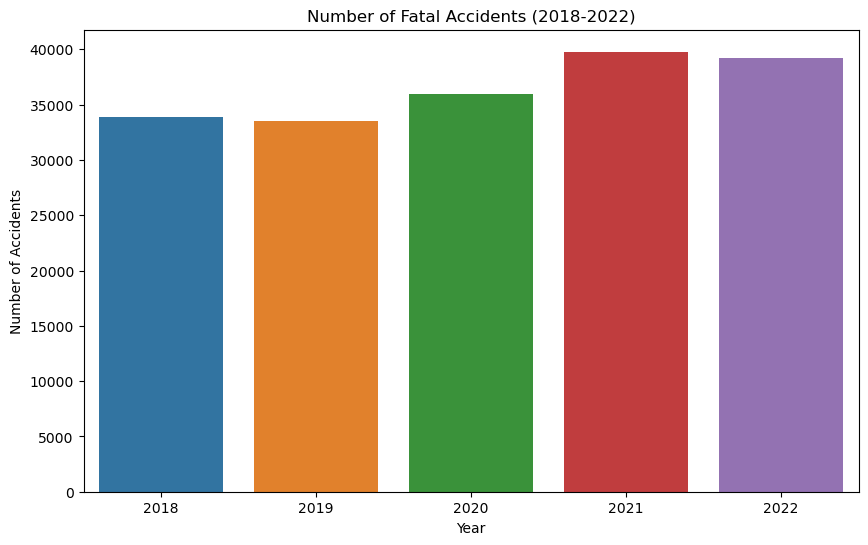

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='YEAR', data=df_accident)
plt.title('Number of Fatal Accidents (2018-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

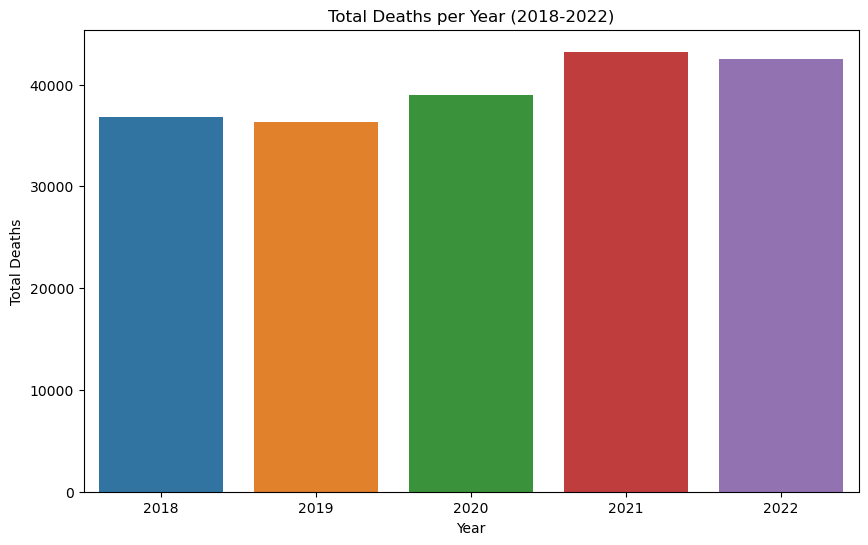

In [36]:
deaths_per_year = df_accident.groupby('YEAR')['FATALS'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='FATALS', data=deaths_per_year)
plt.title('Total Deaths per Year (2018-2022)')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.show()

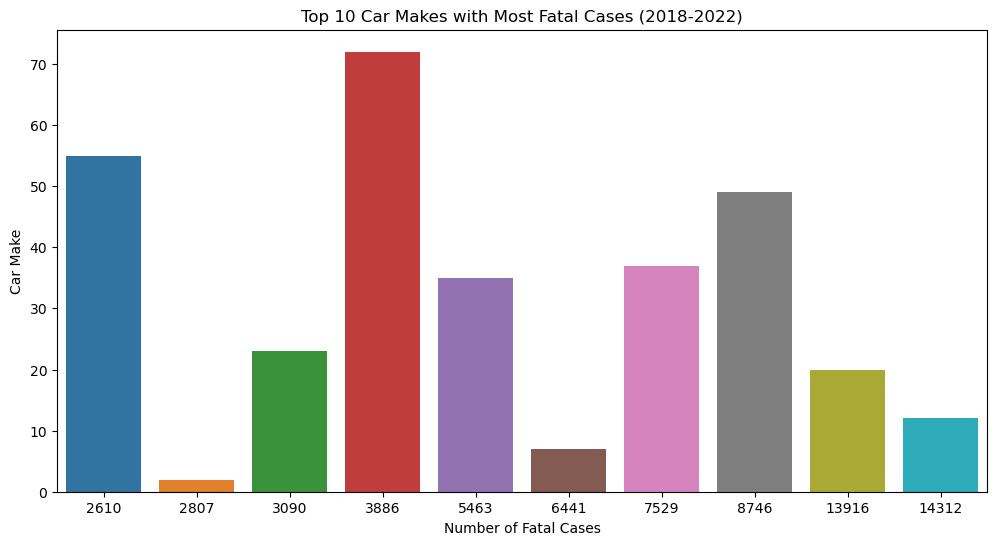

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fatal_cases_by_make = df_vehicle['MAKE'].value_counts().reset_index()
fatal_cases_by_make.columns = ['Car Make', 'Number of Fatal Cases']
top_10_makes = fatal_cases_by_make.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Fatal Cases', y='Car Make', data=top_10_makes)
plt.title('Top 10 Car Makes with Most Fatal Cases (2018-2022)')
plt.xlabel('Number of Fatal Cases')
plt.ylabel('Car Make')
plt.show()

In [34]:
top_10_car_names = top_10_car_makes.index.tolist()
print("Top 10 Car Names:")
for car_name in top_10_car_names:
    print(car_name)


Top 10 Car Names:
12.0
20.0
49.0
37.0
7.0
35.0
72.0
23.0
2.0
55.0


c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


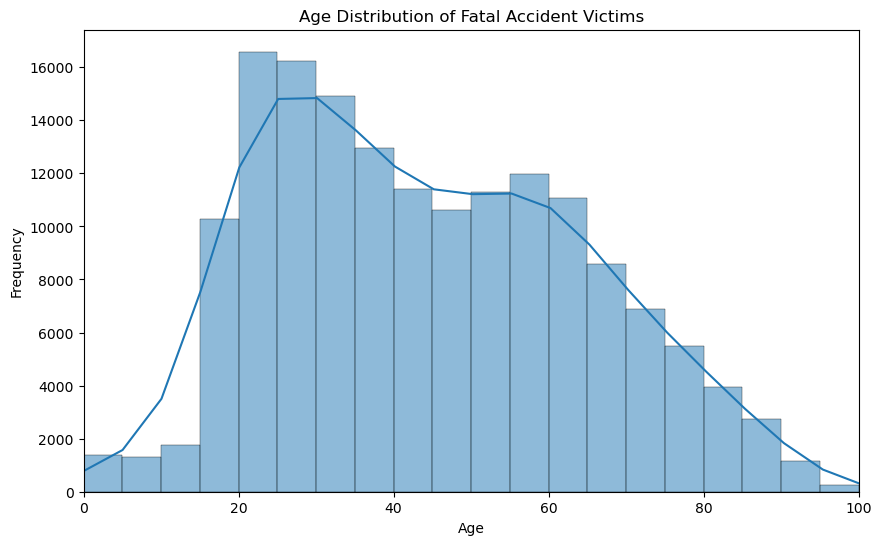

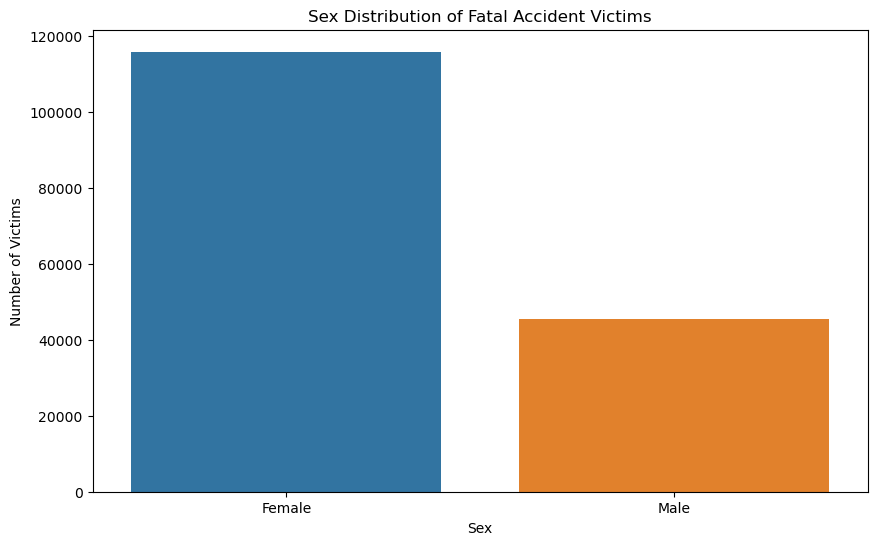

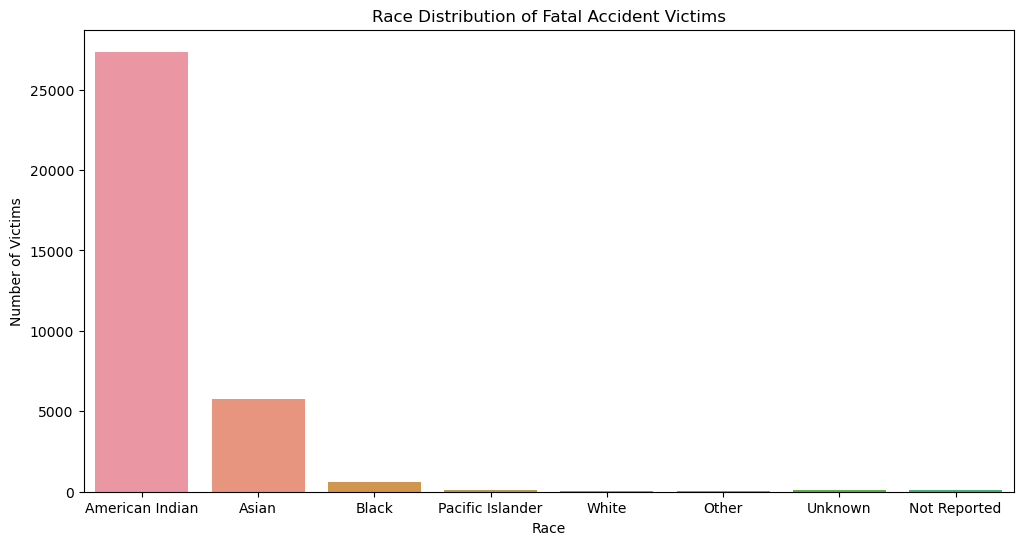

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df_fatal_persons = df_person[df_person['INJ_SEV'] == 4]

plt.figure(figsize=(10, 6))
sns.histplot(df_fatal_persons['AGE'], bins=range(0, 101, 5), kde=True)
plt.title('Age Distribution of Fatal Accident Victims')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100)  
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='SEX', data=df_fatal_persons)
plt.title('Sex Distribution of Fatal Accident Victims')
plt.xlabel('Sex')
plt.ylabel('Number of Victims')
plt.xlim(-0.5, 1.5) 
plt.xticks([0, 1], ['Female', 'Male'])  
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='RACE', data=df_fatal_persons)
plt.title('Race Distribution of Fatal Accident Victims')
plt.xlabel('Race')
plt.ylabel('Number of Victims')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['American Indian', 'Asian', 'Black', 'Pacific Islander', 'White', 'Other', 'Unknown', 'Not Reported'])  # Set the ticks and labels for the x-axis
plt.xlim(-0.5, 7.5)  
plt.show()